In [1]:
from epw import epw

In [2]:
import pandas as pd
CRC_Data = pd.read_csv('CRC_REAL.csv')

In [3]:
new_column_names = ["Hour", "Temperature", "Dew Point", "Humidity", "Wind", 
                    "Speed", "Gust", "Pressure", "Precip.Rate.", 
                    "Precip.Accum.", "UV", "Solar"]
CRC_Data.columns = new_column_names + [CRC_Data.columns[-1]]

In [4]:
for column in CRC_Data.columns:
    if column not in ["Hour", "Wind", "Date"]:
        CRC_Data[column] = CRC_Data[column].astype(str).str.replace(r'[^\d.]', '', regex=True)

In [5]:
CRC_Data = CRC_Data.drop(index=[0, 1])
CRC_Data = CRC_Data.reset_index(drop=True)


In [6]:
# Convert 'Temperature' column from Fahrenheit to Celsius
CRC_Data['Temperature'] = pd.to_numeric(CRC_Data['Temperature'], errors='coerce')
CRC_Data['Temperature'] = (CRC_Data['Temperature'] - 32) * 5.0 / 9.0

# Convert 'Dew Point' column from Fahrenheit to Celsius
CRC_Data['Dew Point'] = pd.to_numeric(CRC_Data['Dew Point'], errors='coerce')
CRC_Data['Dew Point'] = (CRC_Data['Dew Point'] - 32) * 5.0 / 9.0

# Define wind direction to degrees mapping
wind_to_degrees = {
    'North': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'East': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'South': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'West': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}

# Convert 'Wind' column from directions to degrees
CRC_Data['Wind'] = CRC_Data['Wind'].map(wind_to_degrees)

# Convert 'Speed' column to numeric and handle non-numeric values
CRC_Data['Speed'] = pd.to_numeric(CRC_Data['Speed'], errors='coerce')

# Fill any NaN values in 'Speed' with 0 or drop them if necessary
CRC_Data['Speed'] = CRC_Data['Speed'].fillna(0)  # Use .dropna() if you prefer to remove rows

# Convert wind speed from m/s to km/h
conversion_factor = 0.44704
CRC_Data['Speed'] = CRC_Data['Speed'] * conversion_factor

# Convert 'Pressure', 'Precip.Rate.', and 'Precip.Accum.' from inches to meters
inch_to_meter = 0.0254
CRC_Data['Precip.Rate.'] = pd.to_numeric(CRC_Data['Precip.Rate.'], errors='coerce') * inch_to_meter
CRC_Data['Precip.Accum.'] = pd.to_numeric(CRC_Data['Precip.Accum.'], errors='coerce') * inch_to_meter

In [7]:
CRC_Data

,Hour,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip.Rate.,Precip.Accum.,UV,Solar,Date
0,12:00 AM,13.777778,12.777778,93,270.0,0.0,,29.91,0.0,0.0,0.0,0,2023-01-01
1,12:06 AM,13.777778,12.777778,93,225.0,0.0,,29.92,0.0,0.0,0.0,0,2023-01-01
2,12:12 AM,13.777778,12.777778,93,247.5,0.0,,29.91,0.0,0.0,0.0,0,2023-01-01
3,12:18 AM,13.722222,12.777778,93,247.5,0.0,,29.92,0.0,0.0,0.0,0,2023-01-01
4,12:24 AM,13.722222,12.777778,93,225.0,0.0,,29.92,0.0,0.0,0.0,0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54348,11:30 PM,8.388889,1.111111,60,225.0,0.0,,30.01,0.0,0.0,0.0,0,2023-12-31
54349,11:36 PM,8.388889,1.111111,60,225.0,0.0,,30.01,0.0,0.0,0.0,0,2023-12-31
54350,11:42 PM,8.388889,1.111111,60,225.0,0.0,,30.00,0.0,0.0,0.0,0,2023-12-31
54351,11:48 PM,8.388889,1.111111,60,225.0,0.0,,30.00,0.0,0.0,0.0,0,2023-12-31


In [8]:
testing = CRC_Data.copy()

In [9]:
testing['Datetime'] = pd.to_datetime(testing['Date'] + ' ' + testing['Hour'], format='%Y-%m-%d %I:%M %p', errors='coerce')

testing['Year'] = testing['Datetime'].dt.year
testing['Month'] = testing['Datetime'].dt.month
testing['Day'] = testing['Datetime'].dt.day

testing['Hour'] = testing['Datetime'].dt.hour

testing['Hour'] = testing['Hour'] + 1

In [10]:
#set index as the date
testing.set_index('Datetime', inplace=True)

numeric_columns = ['Temperature', 'Dew Point', 'Wind', 'Speed', 'Pressure', 'Precip.Rate.', 'Precip.Accum.']
for col in numeric_columns:
    testing[col] = pd.to_numeric(testing[col], errors='coerce')
    
#these 4 kept disappearing
for col in ['Humidity', 'Gust', 'UV', 'Solar']:
    testing[col] = pd.to_numeric(testing[col], errors='coerce')

# Resample by the specified length and calculate the average for each period
resample_len = 1
hourly_data = testing.resample(f'{resample_len}H').mean()

full_date_range = pd.date_range(start=testing.index.min(), end=testing.index.max(), freq='H')
full_date_range_df = pd.DataFrame(index=full_date_range)

#left join
hourly_data = full_date_range_df.join(hourly_data, how='left')

# Fill NaNs with the mean of each column
hourly_data.fillna(hourly_data.mean(), inplace=True)

# Reset index to turn 'Datetime' back into a column
hourly_data.reset_index(inplace=True)
hourly_data.rename(columns={'index': 'Datetime'}, inplace=True)

# Adjust the hour to start from 1 instead of 0
hourly_data['Hour'] = hourly_data['Datetime'].dt.hour + 1

# Add 'Date' column based on 'Datetime'
hourly_data['Date'] = hourly_data['Datetime'].dt.date

# Reorder columns if necessary
columns_order = ['Datetime', 'Hour', 'Temperature', 'Dew Point', 'Humidity', 'Wind', 'Speed', 'Gust', 'Pressure', 'Precip.Rate.', 'Precip.Accum.', 'UV', 'Solar', 'Date']
# Only include columns that are present in hourly_data
columns_order = [col for col in columns_order if col in hourly_data.columns]

# Reorder DataFrame
hourly_data = hourly_data[columns_order]

print(hourly_data.head())

             Datetime  Hour  Temperature  Dew Point  Humidity    Wind  Speed  \
0 2023-01-01 00:00:00     1    13.677778  12.777778      93.2  258.75    0.0   
1 2023-01-01 01:00:00     2    13.472222  12.777778      94.0  249.75    0.0   
2 2023-01-01 02:00:00     3    13.527778  12.777778      94.0  279.00    0.0   
3 2023-01-01 03:00:00     4    13.055556  12.111111      94.0  290.25    0.0   
4 2023-01-01 04:00:00     5    12.422222  11.666667      94.0  234.00    0.0   

   Gust  Pressure  Precip.Rate.  Precip.Accum.   UV  Solar        Date  
0   NaN    29.913           0.0            0.0  0.0    0.0  2023-01-01  
1   NaN    29.904           0.0            0.0  0.0    0.0  2023-01-01  
2   NaN    29.911           0.0            0.0  0.0    0.0  2023-01-01  
3   NaN    29.918           0.0            0.0  0.0    0.0  2023-01-01  
4   NaN    29.923           0.0            0.0  0.0    0.0  2023-01-01  


C:\Users\zeyuj\AppData\Local\Temp\ipykernel_14536\4066791945.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_data = testing.resample(f'{resample_len}H').mean()


In [11]:
hourly_data = hourly_data.round(1)
hourly_data

,Datetime,Hour,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip.Rate.,Precip.Accum.,UV,Solar,Date
0,2023-01-01 00:00:00,1,13.7,12.8,93.2,258.8,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
1,2023-01-01 01:00:00,2,13.5,12.8,94.0,249.8,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
2,2023-01-01 02:00:00,3,13.5,12.8,94.0,279.0,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
3,2023-01-01 03:00:00,4,13.1,12.1,94.0,290.2,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
4,2023-01-01 04:00:00,5,12.4,11.7,94.0,234.0,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,20,10.4,1.2,53.9,229.5,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31
8756,2023-12-31 20:00:00,21,9.9,1.1,55.1,235.0,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31
8757,2023-12-31 21:00:00,22,9.4,1.1,56.1,229.5,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31
8758,2023-12-31 22:00:00,23,8.9,0.9,57.9,231.8,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31


In [12]:
a = epw()
a.read('USA_GA_Atlanta-Hartsfield-Jackson.Intl.AP.722190_TMY3.epw')
test_df = a.dataframe
comparison = a.dataframe

In [13]:
# Define the custom conversion function
def convert_inhg_to_pa(series):
    return series * 3386.39

In [14]:
test_df['Year'] = 2023
test_df['Dry Bulb Temperature'] = hourly_data['Temperature']
test_df['Dew Point Temperature'] = hourly_data['Dew Point']
test_df['Relative Humidity'] = hourly_data['Humidity']#.astype(int)
test_df['Wind Direction'] = hourly_data['Wind']
test_df['Wind Speed'] = hourly_data['Speed']
# Convert the 'Pressure_inHg' column to Pascals
test_df['Atmospheric Station Pressure'] = hourly_data['Pressure'].apply(convert_inhg_to_pa)

In [15]:
id = 14

print(test_df.columns[id])
print(test_df.iloc[:,id])

Direct Normal Radiation
0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: Direct Normal Radiation, Length: 8760, dtype: int64


In [16]:
test_df

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.7,12.8,93.2,101253.061,...,910,9,999999999,170,0.052,0,88,999.0,999.0,99.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.5,12.8,94.0,101253.061,...,910,9,999999999,170,0.052,0,88,999.0,999.0,99.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.5,12.8,94.0,101253.061,...,850,9,999999999,170,0.052,0,88,999.0,999.0,99.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.1,12.1,94.0,101253.061,...,1160,9,999999999,179,0.052,0,88,999.0,999.0,99.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,12.4,11.7,94.0,101253.061,...,1010,9,999999999,179,0.052,0,88,999.0,999.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,10.4,1.2,53.9,101591.700,...,240,9,999999999,129,0.053,0,88,999.0,999.0,99.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,9.9,1.1,55.1,101591.700,...,270,9,999999999,129,0.053,0,88,999.0,999.0,99.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,9.4,1.1,56.1,101591.700,...,340,9,999999999,129,0.053,0,88,999.0,999.0,99.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,8.9,0.9,57.9,101591.700,...,340,9,999999999,129,0.053,0,88,999.0,999.0,99.0


In [17]:
a.write('Final_CRC.epw')

In [18]:
from uwg import UWG


#16.41666

# Define the .epw, .uwg paths to create an uwg object.
epw_path = "Final_CRC.epw" # available in resources directory.
#USA_GA_Fulton.County.AP-Brown.Field.722195_TMY3.epw

# Initialize the UWG model by passing parameters as arguments, or relying on defaults
model = UWG.from_param_args(epw_path=epw_path, bldheight=11, blddensity=0.4135, 
                                vertohor=0.8, charlength=125, sensanth=0.835,
                                treecover=0.115, grasscover=0.4715, vegstart=3, 
                                vegend=11, albveg=0.15, h_obs= 3, 
                                h_ubl1=700, windmin=7.339,
                                zone='7', nday=365)


model.generate()
model.simulate()

# Write the simulation result to a file.
model.write_epw()


Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [19]:
r = epw()
r.read('Final_CRC_UWG.epw')
result_df = r.dataframe
df_reset  = result_df.copy()

# Step 1: Reset index to move it to a column
df_reset = df_reset.reset_index()

# Step 2: Shift the DataFrame to the right by 1 column
df_shifted = df_reset.shift(1, axis=1)

# Step 3: Drop the last column which is now full of NaNs
df_shifted = df_shifted.iloc[:, :-1].drop("index", axis = 1)
df_shifted

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Visibility,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.8,12.7,92.6,101253.061,...,24.1,910,9,999999999,170,0.052,0,88,999.0,999.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.6,12.6,93.5,101253.061,...,19.3,910,9,999999999,170,0.052,0,88,999.0,999.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.6,12.6,93.6,101253.061,...,16.1,850,9,999999999,170,0.052,0,88,999.0,999.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.2,12.2,93.6,101253.061,...,19.3,1160,9,999999999,179,0.052,0,88,999.0,999.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,12.5,11.5,93.5,101253.061,...,16.1,1010,9,999999999,179,0.052,0,88,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,10.4,1.5,53.8,101591.700,...,9.7,240,9,999999999,129,0.053,0,88,999.0,999.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,9.9,1.3,55.0,101591.700,...,9.7,270,9,999999999,129,0.053,0,88,999.0,999.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,9.4,1.1,56.0,101591.700,...,9.7,340,9,999999999,129,0.053,0,88,999.0,999.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,8.9,1.1,57.8,101591.700,...,9.7,340,9,999999999,129,0.053,0,88,999.0,999.0


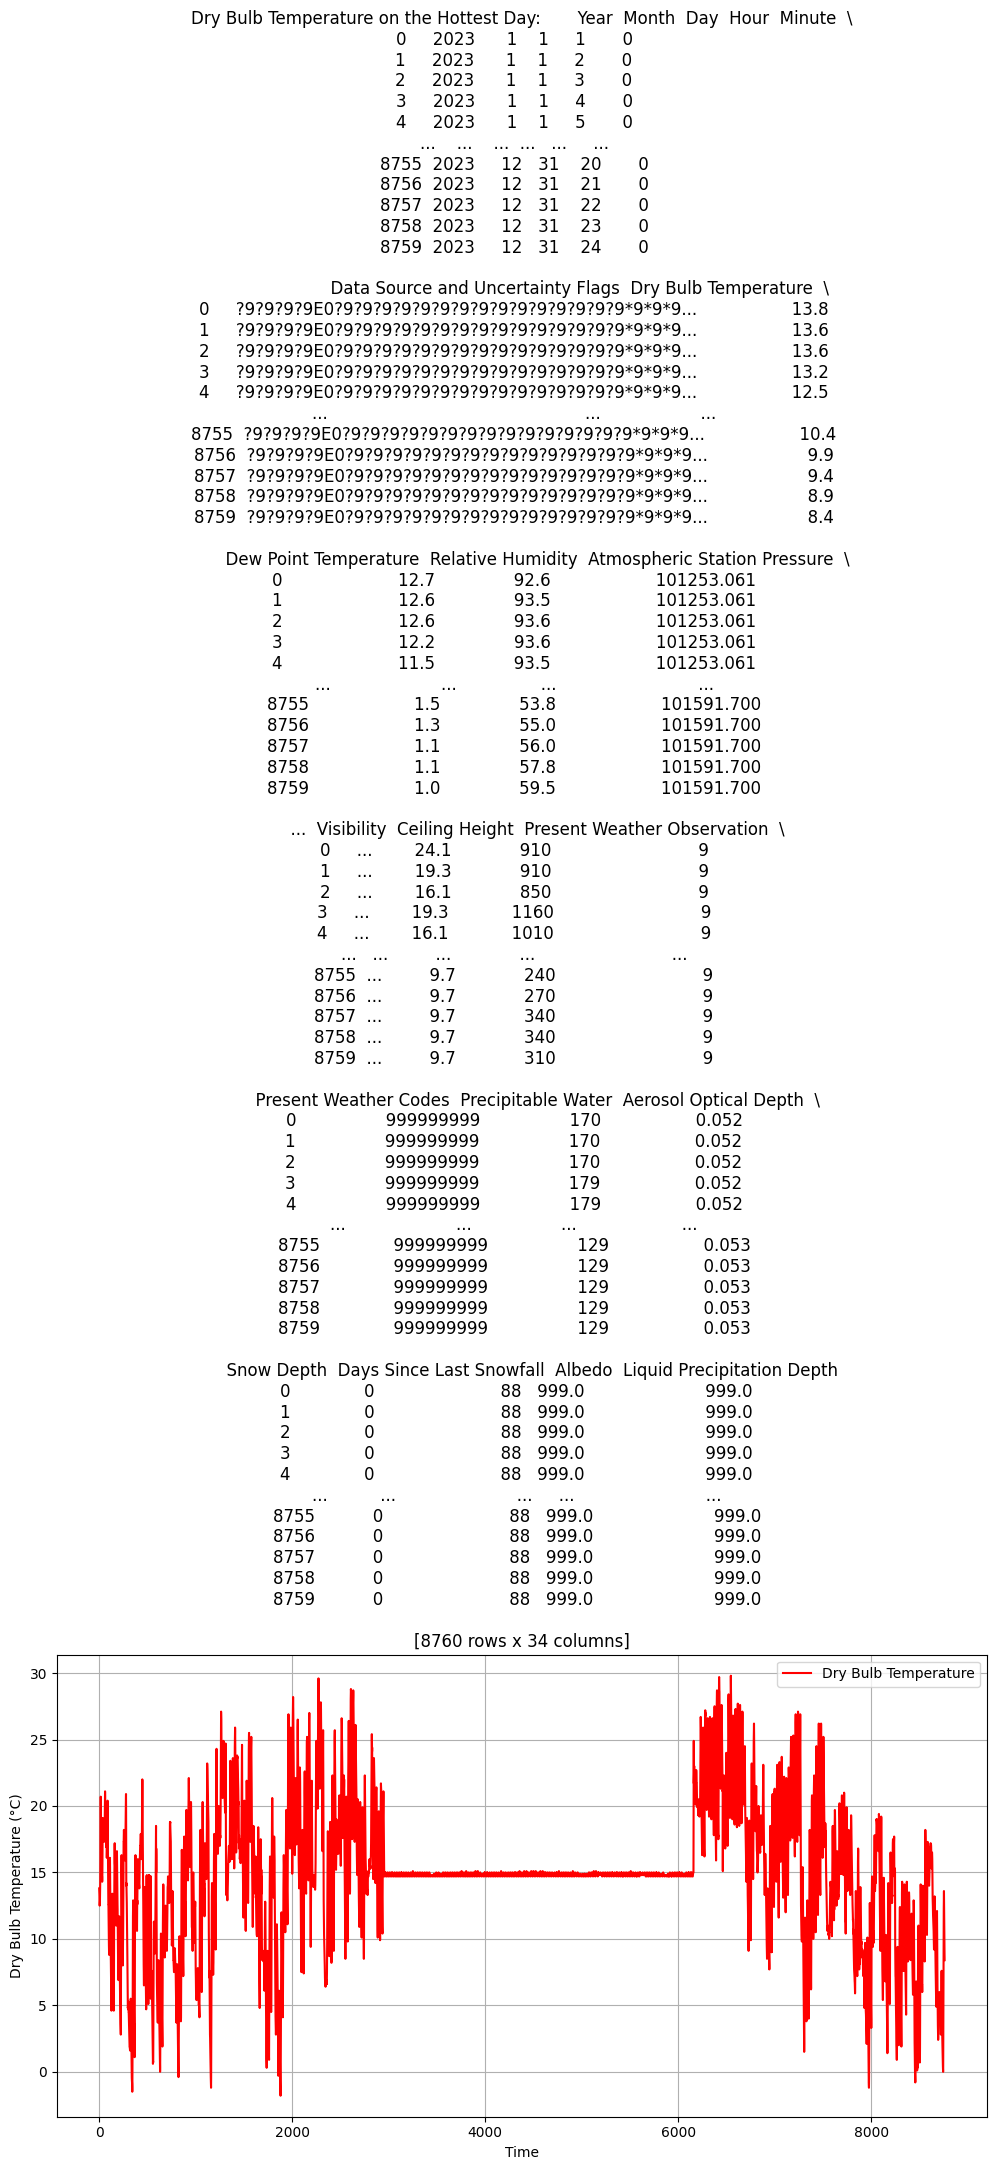

In [20]:
import matplotlib.pyplot as plt


hour = 6785

df_plot = df_shifted[hour:hour+24]

# Plot the temperature values for the hottest day
plt.figure(figsize=(12, 6))
plt.plot(df_shifted.index, df_shifted['Dry Bulb Temperature'], label='Dry Bulb Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Dry Bulb Temperature (°C)')
plt.title(f'Dry Bulb Temperature on the Hottest Day: {df_shifted}')
plt.legend()
plt.grid(True)
plt.show()

Diurnal Averages for Dry Bulb Temperature:
Hour
1     14.121644
2     13.815342
3     13.497260
4     13.241644
5     12.980822
6     12.739726
7     12.588219
8     12.512329
9     12.728767
10    13.428493
11    14.333151
12    15.206301
13    15.950137
14    16.559726
15    16.962192
16    17.172055
17    17.217260
18    16.974795
19    16.564932
20    16.066575
21    15.589315
22    15.161370
23    14.784658
24    14.443014
Name: Dry Bulb Temperature, dtype: float64


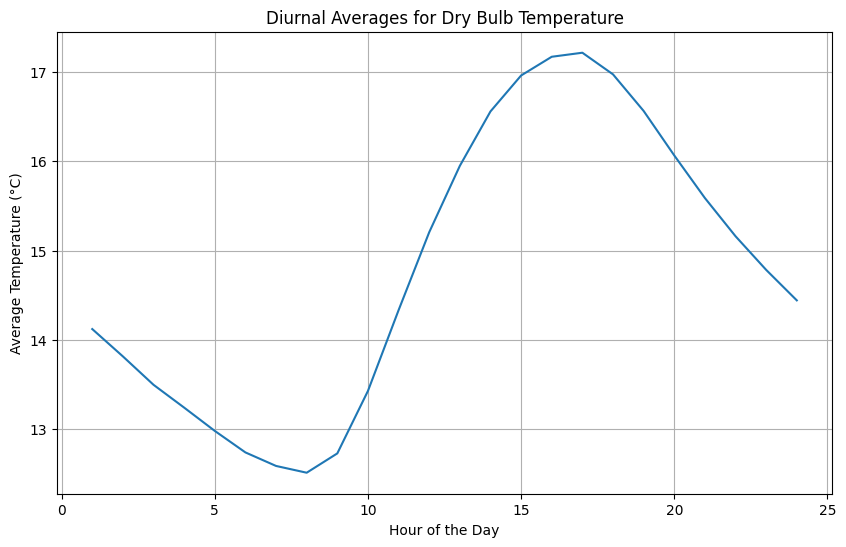

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'epw_df' is your EPW DataFrame and it has an 'Hour' column and a 'Dry Bulb Temperature' column

# Step 1: Calculate Diurnal Averages for 'Dry Bulb Temperature'
diurnal_averages_temp = df_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()

# Step 2: Print out the Diurnal Averages for 'Dry Bulb Temperature'
print("Diurnal Averages for Dry Bulb Temperature:")
print(diurnal_averages_temp)

# Step 3: Plot the Diurnal Averages for 'Dry Bulb Temperature'
diurnal_averages_temp.plot(kind='line', figsize=(10, 6), title='Diurnal Averages for Dry Bulb Temperature')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()


In [22]:
Final_CRC = epw()
Final_CRC.read('Final_CRC.epw')
CRC_df = Final_CRC.dataframe


In [23]:
CRC_df

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.7,12.8,93.2,101253.061,...,910,9,999999999,170,0.052,0,88,999.0,999.0,99.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.5,12.8,94.0,101253.061,...,910,9,999999999,170,0.052,0,88,999.0,999.0,99.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.5,12.8,94.0,101253.061,...,850,9,999999999,170,0.052,0,88,999.0,999.0,99.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,13.1,12.1,94.0,101253.061,...,1160,9,999999999,179,0.052,0,88,999.0,999.0,99.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,12.4,11.7,94.0,101253.061,...,1010,9,999999999,179,0.052,0,88,999.0,999.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,10.4,1.2,53.9,101591.700,...,240,9,999999999,129,0.053,0,88,999.0,999.0,99.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,9.9,1.1,55.1,101591.700,...,270,9,999999999,129,0.053,0,88,999.0,999.0,99.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,9.4,1.1,56.1,101591.700,...,340,9,999999999,129,0.053,0,88,999.0,999.0,99.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9*9...,8.9,0.9,57.9,101591.700,...,340,9,999999999,129,0.053,0,88,999.0,999.0,99.0


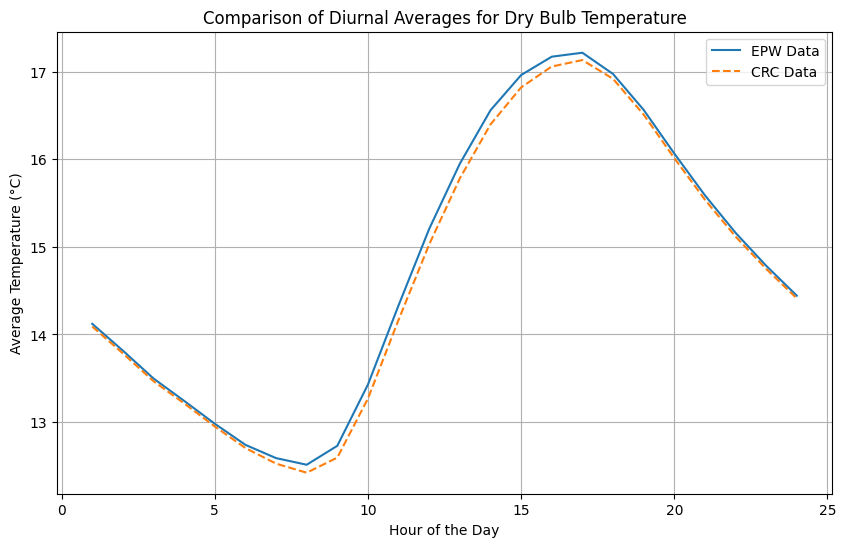

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'epw_df' is your first EPW DataFrame and 'CRC_Data' is the second one
# Both should have 'Hour' and 'Dry Bulb Temperature' columns

# Step 1: Calculate Diurnal Averages for 'Dry Bulb Temperature' for both DataFrames
diurnal_averages_epw = df_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()
diurnal_averages_crc = CRC_df.groupby('Hour')['Dry Bulb Temperature'].mean()

# Step 2: Plot the Diurnal Averages for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(diurnal_averages_epw, label='EPW Data')
plt.plot(diurnal_averages_crc, label='CRC Data', linestyle='--')

# Step 3: Add titles and labels
plt.title('Comparison of Diurnal Averages for Dry Bulb Temperature')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


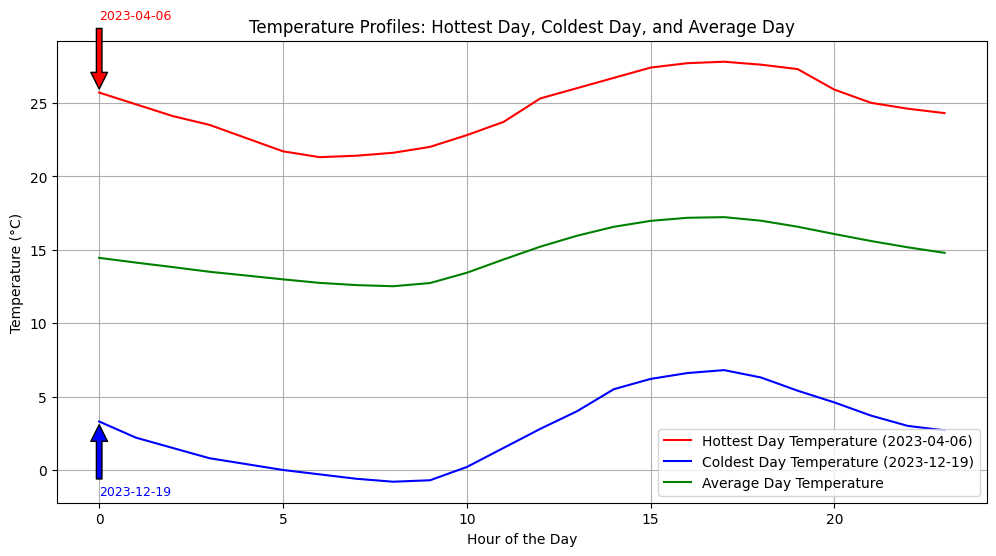

In [25]:
# Convert to datetime
df_shifted['DateTime'] = pd.to_datetime(df_shifted[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Find the hottest and coldest days
daily_temps = df_shifted.groupby(df_shifted['DateTime'].dt.date)['Dry Bulb Temperature'].mean()
hottest_day = daily_temps.idxmax()
coldest_day = daily_temps.idxmin()

# Filter data for the hottest day
hottest_day_data = df_shifted[df_shifted['DateTime'].dt.date == hottest_day]
# Filter data for the coldest day
coldest_day_data = df_shifted[df_shifted['DateTime'].dt.date == coldest_day]

# Calculate the average temperature profile from the entire dataset
average_day_data = df_shifted.groupby(df_shifted['DateTime'].dt.hour)['Dry Bulb Temperature'].mean()

# Plot all three profiles on the same graph
plt.figure(figsize=(12, 6))

# Plot the hottest day
plt.plot(hottest_day_data['DateTime'].dt.hour + hottest_day_data['DateTime'].dt.minute / 60, 
         hottest_day_data['Dry Bulb Temperature'], 
         label=f'Hottest Day Temperature ({hottest_day})', color='red')

# Plot the coldest day
plt.plot(coldest_day_data['DateTime'].dt.hour + coldest_day_data['DateTime'].dt.minute / 60, 
         coldest_day_data['Dry Bulb Temperature'], 
         label=f'Coldest Day Temperature ({coldest_day})', color='blue')

# Plot the average day
plt.plot(average_day_data.index, average_day_data.values, label='Average Day Temperature', color='green')

# Annotate the hottest and coldest days
plt.annotate(f'{hottest_day}', 
             xy=(hottest_day_data['DateTime'].dt.hour.values[0] + hottest_day_data['DateTime'].dt.minute.values[0] / 60, 
                 hottest_day_data['Dry Bulb Temperature'].values[0]), 
             xytext=(hottest_day_data['DateTime'].dt.hour.values[0] + hottest_day_data['DateTime'].dt.minute.values[0] / 60, 
                     hottest_day_data['Dry Bulb Temperature'].values[0] + 5),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=9, color='red')

plt.annotate(f'{coldest_day}', 
             xy=(coldest_day_data['DateTime'].dt.hour.values[0] + coldest_day_data['DateTime'].dt.minute.values[0] / 60, 
                 coldest_day_data['Dry Bulb Temperature'].values[0]), 
             xytext=(coldest_day_data['DateTime'].dt.hour.values[0] + coldest_day_data['DateTime'].dt.minute.values[0] / 60, 
                     coldest_day_data['Dry Bulb Temperature'].values[0] - 5),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=9, color='blue')

plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Profiles: Hottest Day, Coldest Day, and Average Day')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from uwg import UWG

# Define the .epw path to create a UWG object.
epw_path = "Final_CRC.epw"

# Initialize the UWG model
model = UWG.from_param_args(epw_path=epw_path, bldheight=11, blddensity=0.0662, 
                            vertohor=0.8, charlength=125, sensanth=0.835,
                            treecover=0.1845, grasscover=0.5536, vegstart=3, 
                            vegend=11, albveg=0.15, h_obs=3, 
                            h_ubl1=700, windmin=7.339,
                            zone='7', nday=365)

#6.62 bld
#73.81 veg

#18.4525 tree
#55.3575 grass

model.generate()
model.simulate()

# Write the simulation result to a file with a specified name.
model.write_epw()


Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [27]:
science_square = epw()
science_square.read('Final_CRC.epw')
science_df = science_square.dataframe
sciencedf = science_df.copy()

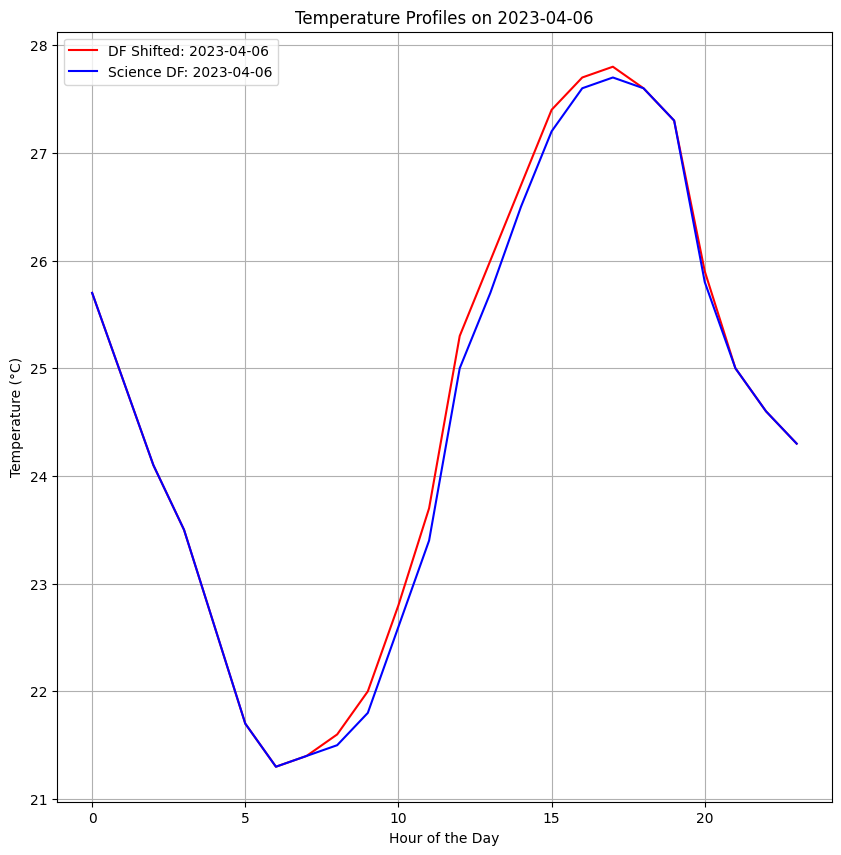

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'DateTime' column exists in df_shifted
if 'DateTime' not in df_shifted.columns:
    df_shifted['DateTime'] = pd.to_datetime(df_shifted[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Ensure 'DateTime' column exists in science_df
if 'DateTime' not in science_df.columns:
    science_df['DateTime'] = pd.to_datetime(science_df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Define the date to compare
date_to_compare = pd.Timestamp('2023-04-06')

# Filter the data for the specified date
data_df_shifted = df_shifted[df_shifted['DateTime'].dt.date == date_to_compare.date()]
data_science_df = science_df[science_df['DateTime'].dt.date == date_to_compare.date()]

# Plot the temperature profiles
plt.figure(figsize=(10, 10))

# Plot the data for df_shifted
plt.plot(data_df_shifted['DateTime'].dt.hour + data_df_shifted['DateTime'].dt.minute / 60, 
         data_df_shifted['Dry Bulb Temperature'], 
         label=f'DF Shifted: {date_to_compare.date()}', color='red')

# Plot the data for science_df
plt.plot(data_science_df['DateTime'].dt.hour + data_science_df['DateTime'].dt.minute / 60, 
         data_science_df['Dry Bulb Temperature'], 
         label=f'Science DF: {date_to_compare.date()}', color='blue')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profiles on {date_to_compare.date()}')
plt.legend()
plt.grid(True)
plt.show()


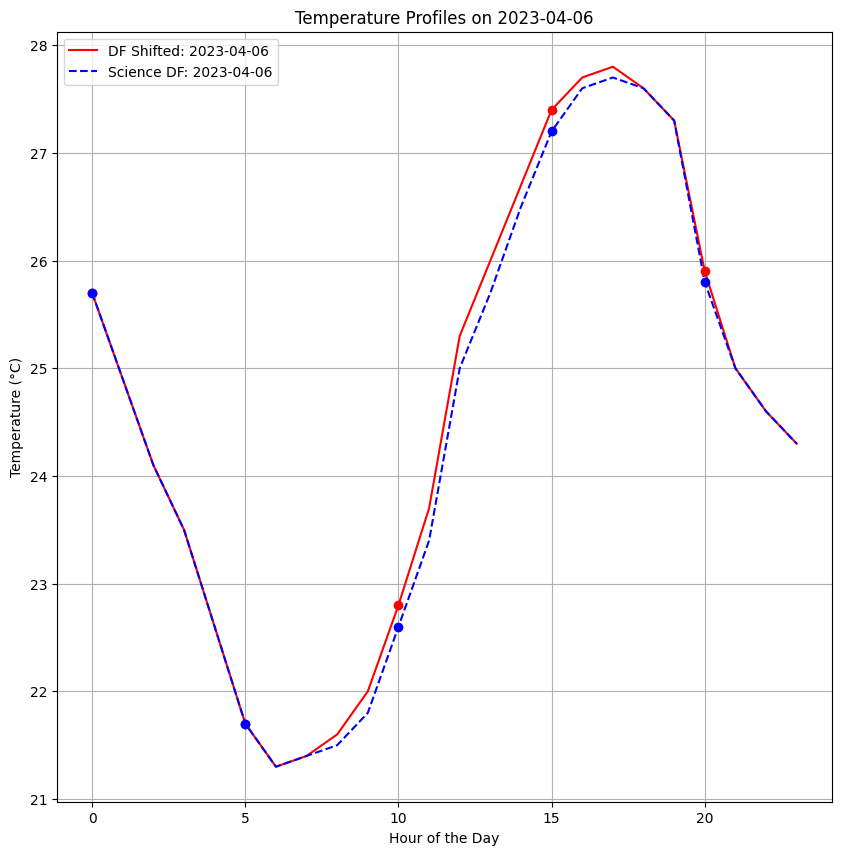

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'DateTime' column exists in df_shifted
if 'DateTime' not in df_shifted.columns:
    df_shifted['DateTime'] = pd.to_datetime(df_shifted[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Ensure 'DateTime' column exists in science_df
if 'DateTime' not in science_df.columns:
    science_df['DateTime'] = pd.to_datetime(science_df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Define the date to compare
date_to_compare = pd.Timestamp('2023-04-06')

# Filter the data for the specified date
data_df_shifted = df_shifted[df_shifted['DateTime'].dt.date == date_to_compare.date()]
data_science_df = science_df[science_df['DateTime'].dt.date == date_to_compare.date()]

# Create the plot
plt.figure(figsize=(10, 10))

# Plot the data for df_shifted with a solid line
plt.plot(data_df_shifted['DateTime'].dt.hour + data_df_shifted['DateTime'].dt.minute / 60, 
         data_df_shifted['Dry Bulb Temperature'], 
         label=f'DF Shifted: {date_to_compare.date()}', color='red', linestyle='-')

# Plot the data for science_df with a dashed line
plt.plot(data_science_df['DateTime'].dt.hour + data_science_df['DateTime'].dt.minute / 60, 
         data_science_df['Dry Bulb Temperature'], 
         label=f'Science DF: {date_to_compare.date()}', color='blue', linestyle='--')

# Add dots at x = 5, 10, 15, 20
for x in range(0, 24, 5):
    df_shifted_y = data_df_shifted.loc[data_df_shifted['DateTime'].dt.hour == x, 'Dry Bulb Temperature']
    science_df_y = data_science_df.loc[data_science_df['DateTime'].dt.hour == x, 'Dry Bulb Temperature']
    if not df_shifted_y.empty:
        plt.plot(x, df_shifted_y.values[0], 'ro')  # Red dot for df_shifted
    if not science_df_y.empty:
        plt.plot(x, science_df_y.values[0], 'bo')  # Blue dot for science_df

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Profiles on {date_to_compare.date()}')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from uwg import UWG

# Define the .epw path to create a UWG object.
epw_path = "science.epw"

# Initialize the UWG model
model = UWG.from_param_args(epw_path=epw_path, bldheight=20, blddensity=0.2, 
                            vertohor=0.8, charlength=125, sensanth=0.835,
                            treecover=0.2, grasscover=0.6, vegstart=3, 
                            vegend=11, albveg=0.15, h_obs=3, 
                            h_ubl1=700, windmin=7.339,
                            zone='7', nday=365)

#original sciencec square inputs
#6.62 bld
#73.81 veg
#18.4525 tree
#55.3575 grass

#1st increment: 78.81: 0.5911 trees and 0.1970 grass and 0.0662
#2nd increment: 83.81: 0.6286 trees and 0.2095 grass and 0.0662
#3rd increment: 88.81: 0.6661 trees and 0.2220 grass and 0.0662


model.generate()
model.simulate()

# Write the simulation result to a file with a specified name.
model.write_epw()



Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [31]:
from uwg import UWG

# Define the .epw path to create a UWG object.
epw_path = "science2.epw"

# Initialize the UWG model
model = UWG.from_param_args(epw_path=epw_path, bldheight=11, blddensity=0.0662, 
                            vertohor=0.8, charlength=125, sensanth=0.835,
                            treecover=0.2095, grasscover=0.6286, vegstart=3, 
                            vegend=11, albveg=0.15, h_obs=3, 
                            h_ubl1=700, windmin=7.339,
                            zone='7', nday=365)

#original sciencec square inputs
#6.62 bld
#73.81 veg
#18.4525 tree
#55.3575 grass

#1st increment: 78.81: 0.5911 trees and 0.1970 grass and 0.0662
#2nd increment: 83.81: 0.6286 trees and 0.2095 grass and 0.0662
#3rd increment: 88.81: 0.6661 trees and 0.2220 grass and 0.0662


model.generate()
model.simulate()

# Write the simulation result to a file with a specified name.
model.write_epw()



Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [32]:
from uwg import UWG

# Define the .epw path to create a UWG object.
epw_path = "science3.epw"

# Initialize the UWG model
model = UWG.from_param_args(epw_path=epw_path, bldheight=11, blddensity=0.0662, 
                            vertohor=0.8, charlength=125, sensanth=0.835,
                            treecover=0.222, grasscover=0.6661, vegstart=3, 
                            vegend=11, albveg=0.15, h_obs=3, 
                            h_ubl1=700, windmin=7.339,
                            zone='7', nday=365)

#original sciencec square inputs
#6.62 bld
#73.81 veg
#18.4525 tree
#55.3575 grass

#1st increment: 78.81: 0.5911 trees and 0.1970 grass and 0.0662
#2nd increment: 83.81: 0.6286 trees and 0.2095 grass and 0.0662
#3rd increment: 88.81: 0.6661 trees and 0.2220 grass and 0.0662


model.generate()
model.simulate()

# Write the simulation result to a file with a specified name.
model.write_epw()



Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [33]:
from epw import epw
science1 = epw()
science1.read('science_UWG.epw')
science1df = science1.dataframe
science1dfdf = science1df.copy()

In [34]:
science2 = epw()
science2.read('science2_UWG.epw')
science2df = science2.dataframe
science2dfdf = science2df.copy()

In [35]:
science3 = epw()
science3.read('science3_UWG.epw')
science3df = science3.dataframe
science3dfdf = science3df.copy()